In [7]:
pip install tensorflow

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade tensorflow_hub

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 108 kB 5.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install keras-tuner --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 96 kB 581 kB/s eta 0:00:011
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9552 sha256=ab68880f7a0c2bdafcb714a6577617e36761470cdb3000dd3d1b934d35c00fa7
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import boto3
from sagemaker import get_execution_role
import sagemaker

In [117]:
#  S3 defailt bucket
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
prefix = 'signlanguage-demo'
print("Using bucket " + bucket)

Using bucket sagemaker-us-east-2-708870595954


In [118]:
# send data to S3. SageMaker will take training data from s3
train_path = sess.upload_data(
    path="Data/sign_mnist_train.csv", bucket=bucket, key_prefix=prefix)
test_path = sess.upload_data(
    path="Data/sign_mnist_test.csv", bucket=bucket, key_prefix=prefix)
print(train_path)

s3://sagemaker-us-east-2-708870595954/signlanguage-demo/sign_mnist_train.csv


In [115]:
#reading data
#train_data = pd.read_csv("Data/sign_mnist_train.csv")
train_data = pd.read_csv(train_path)
print(train_data.shape)
train_data.head()

#basically in our dataset we are given lable for the corrosponding gasture and 784 (28 x 28) pixel values represting an image
#Training data contains 27455 images
#test data contains 7172 images

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [36]:
#Data preprocessing
#converting array to images(tensors)

#visulaizing lables and making sure that dataset is balanced

#performing one hot encoding for lables

In [116]:
test_data = pd.read_csv(test_path)
print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [38]:
y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

In [39]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

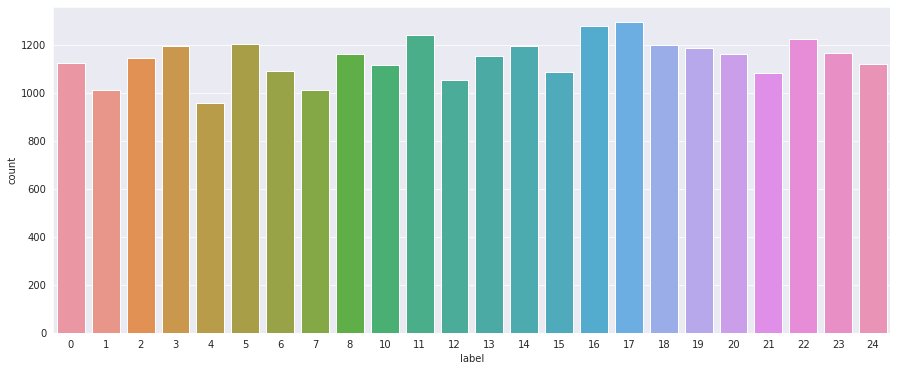

In [40]:
# visulaizing the data
plt.figure(figsize=(15,6))
sns.set_style("darkgrid");
sns.countplot(y_train);

In [41]:
#This really nice visual tells us that there are nearly 1k examples for each class output so we can consider this 
#dataset as a balanec dataset because there's no class suffering from very less or too much examples

#Now the question arrises that why we didnt check the same thing for test data .... and the ans is we dont really 
# need that.
#In our training set we check the balance of the data coz we want to learn our model perfactly for each class 
#we dont want it to be biased for a subset of possible classes, while in test set the whole paper can be from linear algebra , no worries in that case

In [42]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

y_train[:2]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [43]:
#so basically LabelBinarizer performed OHE sort of stuff on our training data .
#Now let's write a function wich can take our array of images and can return a well shaped wranggled array .

In [83]:
def preprocess_image(x):
    
    """
    we know that the pixcel values lies between 0-255 but it is obsearved that models performs exceptionally well if we scale pixel values
    between 0-1"""
    x = x/255
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image
    #x = x.reshape(28,28)
    return x

In [84]:
train_x = preprocess_image(train_data.values)
test_x = preprocess_image(test_data.values)

In [85]:
#Let's write a function which

    #takes images array as input
    #displays 10 images from it(first 10)

In [97]:
def show_images(images,labels):
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(tf.squeeze(images[k]) , cmap='gray')
            ax[i,j].set_title(str(unique_labels[np.argmax(y_train[k])]))
            k = k+1;
    plt.tight_layout()

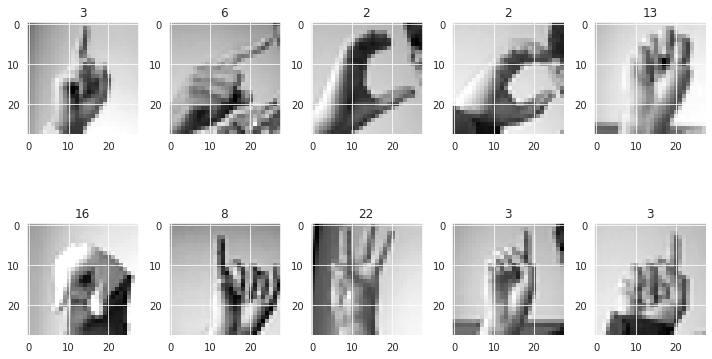

In [98]:
#let's see first 10 images from training set
show_images(train_x,y_train)

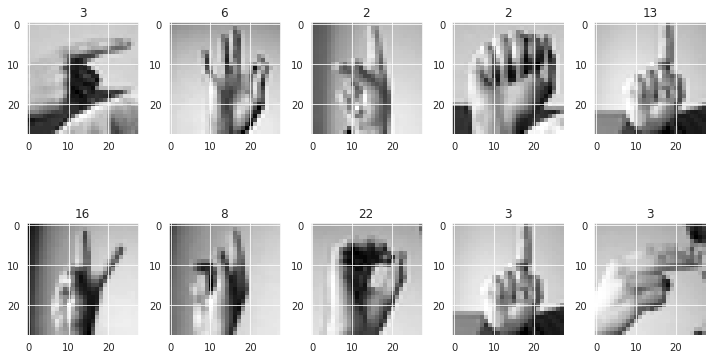

In [99]:
#let's visualize test images as well
show_images(test_x,y_test)


In [100]:
"""Data Augmentation¶
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for 
training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.

This can expand our dataset artifically and make it robust , that couses variety in data and this can save us 
from overfitting."""

'Data Augmentation¶\nData augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for \ntraining models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.\n\nThis can expand our dataset artifically and make it robust , that couses variety in data and this can save us \nfrom overfitting.'

In [102]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)


In [ ]:
"""Buidling the CNN model
we will be building a CNN model to classify images , as usual we will try a few of conv2d layers along with batchNormalization and regulization(dropout) and then fallten layer then dense
layer ."""

In [103]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',
        
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    
    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),  
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [104]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

In [105]:
tuner_search.search(train_x,y_train,epochs=5,validation_data = (test_x, y_test))

Trial 1 Complete [00h 11m 07s]
val_accuracy: 0.9121583700180054

Best val_accuracy So Far: 0.9121583700180054
Total elapsed time: 00h 11m 07s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
conv_1_filter     |100               |200               
conv_2_filter     |125               |75                
drop_1_rate       |0.1               |0.1               
conv_3_filter     |50                |25                
dense_1_units     |960               |160               
drop_2_rate       |0.3               |0.1               
learning_rate     |0.001             |0.01              

Epoch 1/5
858/858 [==============================] - 94s 110ms/step - loss: 0.2080 - accuracy: 0.9385 - val_loss: 0.8632 - val_accuracy: 0.7773
Epoch 2/5
858/858 [==============================] - 96s 111ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0984 - val_accuracy: 0.9764
Epoch 3/5
858/858 [==============================] - 96s 112ms/step - loss: 3.0232e-04

KeyboardInterrupt: 

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0] #this will give us the best tuned model

In [ ]:
"""Now let's create a callback
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

we will reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is
reduced."""

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
#now let's train the model

In [ ]:
history = model.fit(datagen.flow(train_x,y_train, batch_size = 128) 
                    ,epochs = 20
                    , validation_data = (test_x, y_test)
                    , callbacks = [lr_reduction])

In [ ]:
#well, we got 100% accuracy on our test data .
#Analyse the trained model

In [ ]:
model.summary()

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
#let's now plot the model architecture
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
#Now let's make some predictions on test data and see the confusion metrix

In [ ]:
predictions = model.predict(test_x)

In [ ]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [ ]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

In [ ]:
accuracy_score(y_test_labels,y_pred_labels)

In [ ]:
cm= confusion_matrix(y_test_labels,y_pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,cmap='twilight_shifted')